In [26]:
import copy
import os, sys
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
import warnings
import requests
from collections import Counter, defaultdict
from shapely import LineString, Polygon, Point
from scipy.interpolate import make_interp_spline 
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import pygmt
import seaborn as sns
from sklearn import preprocessing


from pyproj import Transformer
from pyproj import Proj


In [27]:


# form list of polygons that are symetric lines parallel to the faults from both side, at interval "interval" [deafult=0.5] from each other
# max_distance default = 30
# function gets df: dataframe of x and y points that represent the geometry of a fault
# ax: figure subplot
def make_polygons_list(dataframe, ax, interval = 0.5, max_distance = 30):
    vector = np.arange(0.5, max_distance, interval)
    polygon_list = []
    points = list(zip(dataframe['x'],dataframe['y']))
    rectangle = LineString(points)
    old_pol = Polygon()
    for i in range(len(vector)):
        s = gpd.GeoSeries(rectangle)
        buffered_rectangle = s.buffer(vector[i],cap_style=2) 
        buffered_rectangle_1 = buffered_rectangle.difference(old_pol)
        old_pol = buffered_rectangle
        polygon_list.append(buffered_rectangle_1)
    # plotting two polygons for check
    gpd.GeoSeries(polygon_list[5]).plot(ax=ax, color='green')
    # gpd.GeoSeries(polygon_list[30]).plot(ax=ax, color='r')
    return polygon_list

# forms two lists of density functions for two population: declustered catalog (mainschoks + background), aftershocks and full catalog.
# or for deep interval or shallow
# mains: declustered catalog dataframe, afterschoks: afterschoks dataframe, all cat: full catalog dataframe.
# interval [deafult=0.5] {both interval and max distance must be euqal in the functions mamake_polygons_list and cal_density
# max_distance default = 30
def cal_density(mains, aftershocks, polygon_list, interval = 0.5, max_distance = 30):  
    i = 0
    vector = np.arange(interval, max_distance, interval)
    events_per_distance_square = np.zeros(len(vector))
    events_per_distance_square_2 = np.zeros(len(vector))
    events_per_distance_square_3 = np.zeros(len(vector))
    areas=[]
    for poly in polygon_list:
        area = poly.area 
        areas.append(area)
        mains['is_inside'] = mains.apply(lambda row: poly.contains(Point(row['x'], row['y'])), axis=1)
        aftershocks['is_inside'] = aftershocks.apply(lambda row: poly.contains(Point(row['x'], row['y'])), axis=1)
        # all_cat['is_inside'] = all_cat.apply(lambda row: poly.contains(Point(row['x'], row['y'])), axis=1)
        events_per_distance_square[i] = (float(len(mains[(mains['is_inside'] == True)])) / area)
        events_per_distance_square_2[i] = (float(len(aftershocks[(aftershocks['is_inside'] == True)])) / area)
        # events_per_distance_square_3[i] = (float(len(all_cat[(all_cat['is_inside'] == True)])) / area)
        i = i + 1
    return vector, events_per_distance_square, events_per_distance_square_2##, events_per_distance_square_3




##plots density functions of two populations with smoothed function
def plot_density_two_functions(vector, events_per_distance_square_3,events_per_distance_square_4, ax,string,string2,c_depth,legend_loc, txtbox_loc,title): 
    ax.scatter(vector, events_per_distance_square_3/events_per_distance_square_3.max(), s=30, facecolors='none', edgecolors='purple', linewidth=3,alpha=0.6)
    ax.scatter(vector, events_per_distance_square_4/events_per_distance_square_4.max(), s=30, facecolors='none', edgecolors='darkgreen', linewidth=3,alpha=0.6)
    legend1 = ax.legend(labels=[string,string2],title=title, loc=legend_loc, fontsize=10, borderpad=0.5)
    x_smooth3 = vector
    y_smooth3 = savgol_filter(events_per_distance_square_3,15, 2, mode='nearest')
    x_smooth4 = vector
    y_smooth4 = savgol_filter(events_per_distance_square_4,15, 2, mode='nearest')
    ax.plot(x_smooth3, y_smooth3/y_smooth3.max(), c='purple', linewidth=4)
    ax.plot(x_smooth4, y_smooth4/y_smooth4.max(), c='darkgreen', linewidth=4,alpha=0.85)
    peak3 = (np.array(y_smooth3[0:35])).max()
    peak4 = (np.array(y_smooth4[0:35])).max()
    threshold_value3 = peak3 * 0.3
    threshold_value4 = peak4 * 0.3
    largest_point3 = x_smooth3[0:35][[True if y < threshold_value3 else False for y in y_smooth3[0:35]].index(True)]
    largest_point4 = x_smooth4[0:35][[True if y < threshold_value4 else False for y in y_smooth4[0:35]].index(True)]
    ax.axvline(x=largest_point3, ymin=0, ymax=1,color='purple', linewidth=5)
    ax.axvline(x=largest_point4, ymin=0, ymax=1,color='darkgreen', linewidth=5)
    rms_error = np.sqrt(np.mean((y_smooth3/y_smooth3.max() - events_per_distance_square_3/events_per_distance_square_3.max())**2))
    rms_error_4 = np.sqrt(np.mean((y_smooth4/y_smooth4.max() - events_per_distance_square_4/events_per_distance_square_4.max())**2))
    ax.text(largest_point3,txtbox_loc, f"{largest_point3}", fontsize=14,bbox=dict(facecolor='white', edgecolor='grey',  linewidth=2, boxstyle='round'),  weight='bold',fontfamily='serif', color='purple')
    ax.text(largest_point4,0.4, f"{largest_point4}", fontsize=14,bbox=dict(facecolor='white', edgecolor='grey',  linewidth=2, boxstyle='round'),  weight='bold',fontfamily='serif', color='darkgreen')
    ax.text(15,0.6, f" RMS {round(rms_error,2)}", fontsize=10,bbox=dict(facecolor='white', edgecolor='purple',  linewidth=2, boxstyle='round'),  weight='bold',fontfamily='serif', color='black')
    ax.text(15,0.7, f" RMS {round(rms_error_4,2)}", fontsize=10,bbox=dict(facecolor='white', edgecolor='darkgreen',  linewidth=2, boxstyle='round'),  weight='bold',fontfamily='serif', color='black')

    # ax.set_xlabel('Distance from Fault (km)', fontsize=15, fontfamily='serif', fontweight='bold', color='black', backgroundcolor='white')
    # ax.set_ylabel('Normalized\n Density (events/km\u00b2)', fontsize=15, fontfamily='Ariel', fontweight='bold', color='black', backgroundcolor='white')
    
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)


## get 50% and 99% of depth interval
def plot_histogram(bg_e1, ax):
    depth = bg_e1['Depth'] # get the depth column from the dataframe
    weights = np.ones(len(bg_e1)) / len(bg_e1)
    ax.invert_yaxis()
    ci = np.percentile(depth, [0, 50])
    c50 = np.percentile(depth, [0, 99])# change the percentiles to get the 95% interval
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_ylabel('Depth (km)', fontsize =16, fontfamily='serif' )
    ax.set_xlabel('Number of events', fontsize =16, fontfamily='serif' )
    bg_e1.plot.hist(y='Depth', bins=np.arange(0, 42, 2), orientation='horizontal', color='black', edgecolor='grey', linewidth=2, ax=ax,histtype=u'step')
    ax.legend().remove()
    ax.axhline(ci[0], color='r', linestyle='--') # add this line to plot the lower limit of the interval as a dashed red line
    ax.axhline(ci[1], color='r', linestyle='--')
    ax.axhline(c50[1], color='blue', linestyle='--')# add this line to plot the upper limit of the interval as a dashed red line
    ax.set_xlim(0,100)
    ax.set_ylim(45,-4)
    ax.text(30,
            round(ci[1])+1,
            f"{round(ci[1])}", 
            fontsize=15,
            bbox=dict(facecolor='white', edgecolor='grey',  linewidth=2, boxstyle='round'),  weight='bold',fontfamily='serif', color='red')
    ax.text(50,
            round(c50[1]+1),
            f"{round(c50[1])}", 
            fontsize=15,
            bbox=dict(facecolor='white', edgecolor='grey',  linewidth=2, boxstyle='round'),  weight='bold',fontfamily='serif', color='blue')
    return ci,c50 


def get_bg_cat_in_polygon(bg_e, fault_line):
    points = list(zip(fault_line['x'],fault_line['y']))
    rectangle = LineString(points)
    s = gpd.GeoSeries(rectangle)
    buffered_rectangle = s.buffer(30,cap_style=2) 
    bg_e['is_inside'] = bg_e.apply(lambda row: buffered_rectangle.contains(Point(row['x'], row['y'])), axis=1)
    bg_e1 = bg_e[(bg_e['is_inside']==True)]
    return bg_e1


def get_bg_e_up_down(bg, ci, c50):
    bg_e_up = bg[bg["Depth"].between(0, round(ci[1]))]
    bg_e_down = bg[bg["Depth"].between(round(ci[1]), round(c50[1]))]
    return bg_e_up, bg_e_down

In [28]:
## workflow 


## read data
mainshocks_e = pd.read_csv('mainschoks_e_anatolian.csv')
bg_e = pd.read_csv('bg_e_anatolian.csv')
aftershocks_e = pd.read_csv('aftershocks_e_anatolian.csv')
# all_DST = pd.read_csv('israel_23.declust.ZnBZ.csv')
fault_line = pd.read_csv('marmar_west_interp.csv')


## trasnform to xy

from pyproj import Proj
from pyproj import Transformer
#lon,lat
region = [mainshocks_e.Lon.min(), mainshocks_e.Lon.max(), mainshocks_e.Lat.min(), mainshocks_e.Lat.max()]

dlat = region[3] - region[2]
cproj = Proj(proj="longlat", ellps="WGS84", datum="WGS84", no_defs=True)
gproj = Proj(proj="lcc", lon_0=region[0], lat_0=region[2], lat_1=region[2]  + dlat * 0.25, lat_2=region[2]  + dlat * 0.75,
             datum="WGS84", ellps="WGS84", units="km", no_defs=True)
transformer_local2lonLat = Transformer.from_proj(gproj, cproj)

transformer_lonLat2local = Transformer.from_proj(cproj, gproj)
mainshocks_e['x'], mainshocks_e['y'] = transformer_lonLat2local.transform(mainshocks_e.Lon,mainshocks_e.Lat)
bg_e['x'], bg_e['y'] = transformer_lonLat2local.transform(bg_e.Lon,bg_e.Lat)
aftershocks_e['x'], aftershocks_e['y'] = transformer_lonLat2local.transform(aftershocks_e.Lon,aftershocks_e.Lat)
fault_line['x'], fault_line['y'] = transformer_lonLat2local.transform(fault_line.lon,fault_line.lat)


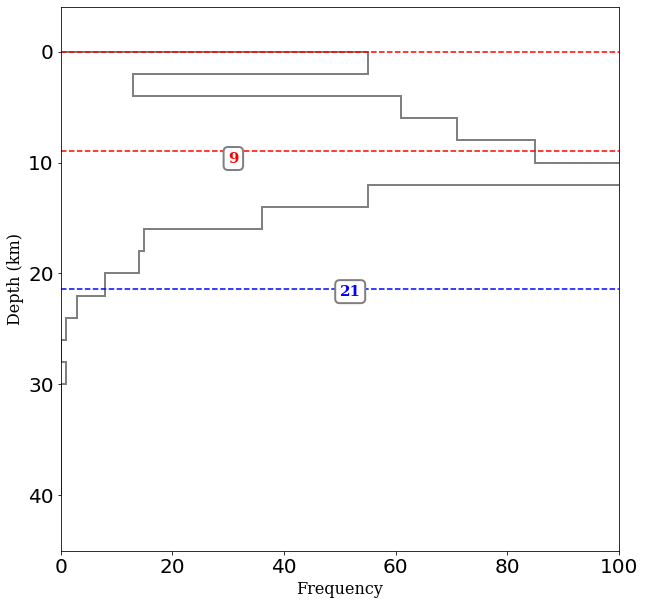

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

#1
## get events in polygon of 30 km from fault on each side
bg_e1 = get_bg_cat_in_polygon(bg_e, fault_line)

## get depth of 50% of events and 99% of events
ci, c50 = plot_histogram(bg_e1,ax)

## seperate events to two dfs for each depth interval
bg_e_up1,bg_e_down1 = get_bg_e_up_down(bg_e1, ci, c50)

/var/folders/7s/rxqw810j785_t_43yjy71ldh0000gq/T/ipykernel_45271/515041861.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg['is_inside'] = bg.apply(lambda row: poly.contains(Point(row['x'], row['y'])), axis=1)


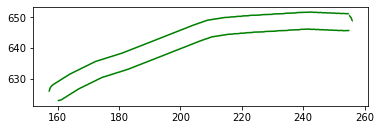

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

## make list of ploygons parallel to the fault, with 0.5 km interval each
polygon_list_1 = make_polygons_list(fault_line,ax, interval = 0.5, max_distance = 30)

##calculate density of each population

vector, events_per_distance_square_clf_df1_bg_up = cal_density_three_comp(bg_e_up1, polygon_list_1)
vector, events_per_distance_square_clf_df1_bg_down = cal_density_three_comp(bg_e_down1, polygon_list_1)

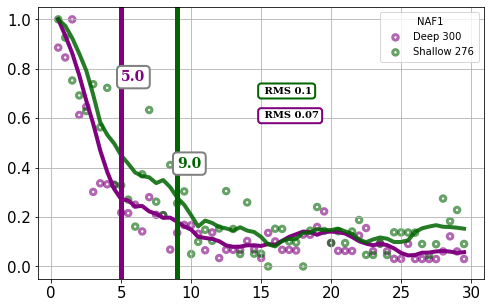

In [31]:
##plot density functions

fig, ax = plt.subplots(1,1, figsize=(8,5))



vector = np.arange(0.5, 30, 0.5)
xticks = np.arange(0, 30, 5)
yticks = np.arange(0, 1.2, 0.2)

#df1


plot_density_two_functions(vector, events_per_distance_square_clf_df1_bg_down,events_per_distance_square_clf_df1_bg_up, ax,f'Deep {len(bg_e_down1)}',f'Shallow {len(bg_e_up1)}', 'blue','upper right',0.75,'NAF1')
ax.grid()